In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5), (0.5))
])
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(
    dataset=mnist_data,
    batch_size=64,
    shuffle=True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Generate the batches of Image and labels
dataiter = iter(data_loader)
images, labels = dataiter.next()

# Get the minimum and maximum using torch for the images.
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, 7)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: For `nn.MaxPool2d` use `nn.MaxUnpool2d`, or use different kernelsize, stride and such.
# For `Input [-1, +1]` use `nn.Tanh`

In [5]:
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 12),
            nn.ReLU(),

            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),

            nn.Linear(12, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# For `Input [-1, +1]` use `nn.Tanh`

In [6]:
# Training the model!
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

In [8]:
num_epochs = 30
outputs = []

for epoch in range(num_epochs):
    for img, _ in data_loader:
        # img = img.reshape(-1, 28*28) # For the linear Autoencoder

        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0052
Epoch:2, Loss:0.0038
Epoch:3, Loss:0.0037
Epoch:4, Loss:0.0035
Epoch:5, Loss:0.0032
Epoch:6, Loss:0.0033
Epoch:7, Loss:0.0029
Epoch:8, Loss:0.0026
Epoch:9, Loss:0.0028
Epoch:10, Loss:0.0023
Epoch:11, Loss:0.0027
Epoch:12, Loss:0.0027
Epoch:13, Loss:0.0031
Epoch:14, Loss:0.0027
Epoch:15, Loss:0.0024
Epoch:16, Loss:0.0024
Epoch:17, Loss:0.0028
Epoch:18, Loss:0.0025
Epoch:19, Loss:0.0026
Epoch:20, Loss:0.0026
Epoch:21, Loss:0.0026
Epoch:22, Loss:0.0027
Epoch:23, Loss:0.0023
Epoch:24, Loss:0.0023
Epoch:25, Loss:0.0027
Epoch:26, Loss:0.0020
Epoch:27, Loss:0.0025
Epoch:28, Loss:0.0025
Epoch:29, Loss:0.0025
Epoch:30, Loss:0.0027


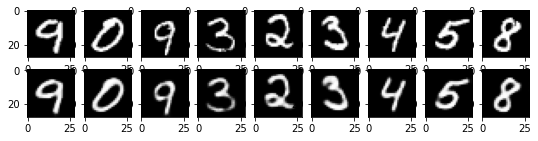

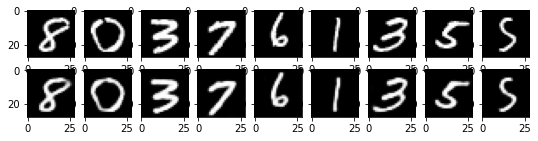

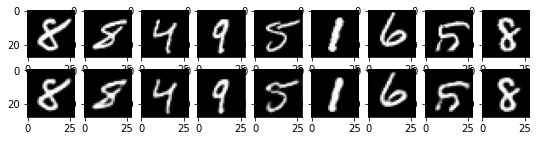

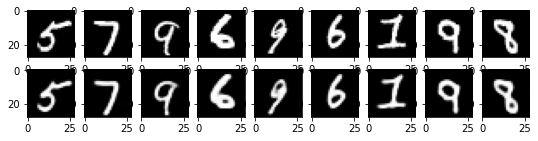

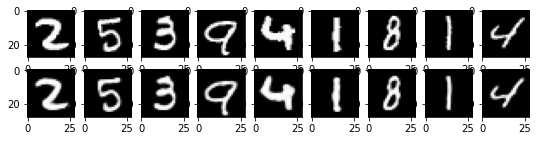

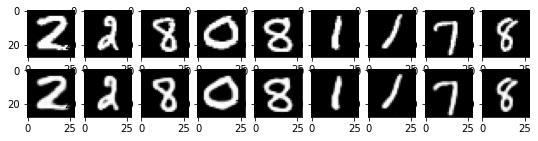

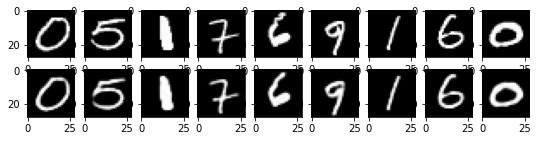

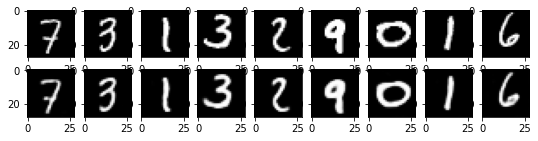

In [9]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()

    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9:
          break
  
        plt.subplot(2, 9, i + 1)
        # item = item.reshape(-1, 28,28) # For the linear Autoencoder
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9:
          break

        plt.subplot(2, 9, 9 + i + 1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        plt.imshow(item[0])


In [10]:
# Save the model
torch.save(model.state_dict(), "autoencoder.bin")